In [65]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from backtesting import Strategy
from backtesting import Backtest
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tqdm.pandas()


def read_data(symbol, period, interval):
    data = pd.read_csv(f'../data/{symbol}-{period}-{interval}.csv')
    data.Datetime = pd.to_datetime(data.Datetime, utc=True)
    # data.set_index('Datetime', inplace=True)
    data.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)
    return data


def set_ema(data, ema_length):
    data['EMA'] = ta.ema(data.Close, length=ema_length)
    return data


def set_macd(data):
    macd = ta.macd(data.Close)
    data['MACD'] = macd.loc[:, 'MACD_12_26_9']
    data['MACD_signal'] = macd.loc[:, 'MACDs_12_26_9']
    data['MACD_histogram'] = macd.loc[:, 'MACDh_12_26_9']
    return data


def set_atr(data):
    data['ATR'] = ta.atr(data.High, data.Low, data.Close, length=7)
    return data


def ema_trade_signal(data, current, back_candles):
    start = max(0, current - back_candles)
    rows = data.loc[start:current]

    if all(rows.High < rows.EMA):
        return -1
    elif all(rows.Low > rows.EMA):
        return 1
    else:
        return 0


def set_ema_trade_signal(data):
    data['EMA_trade_signal'] = data.progress_apply(
        lambda r: ema_trade_signal(data, r.name, 5), axis='columns'
    )
    return data


def macd_trade_signal(data, current):
    if (
        all(data.loc[current - 3:current - 2, 'MACD'] <
            data.loc[current - 3:current - 2, 'MACD_signal']) and
        all(data.loc[current - 1:current, 'MACD'] >
            data.loc[current - 1:current, 'MACD_signal'])
    ):
        return 1
    if (
        all(data.loc[current - 3:current - 2, 'MACD'] >
            data.loc[current - 3:current - 2, 'MACD_signal']) and
        all(data.loc[current - 1:current, 'MACD'] <
            data.loc[current - 1:current, 'MACD_signal'])
    ):
        return -1
    return 0


def set_macd_trade_signal(data):
    data['MACD_trade_signal'] = data.progress_apply(
        lambda r: macd_trade_signal(data, r.name),
        axis='columns'
    )
    return data

def total_trade_signal(row):
    if (row.EMA_trade_signal == 1 & row.MACD_trade_signal == 1):
        return 1
    elif (row.EMA_trade_signal == -1 & row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

def set_total_trade_signal(data):
    data['Total_trade_signal'] = data.progress_apply(
        lambda r: total_trade_signal(r),
        axis='columns'
    )
    return data


class MacdStrategy(Strategy):
    mysize = 3
    slcoef = 1.1
    TPSLRatio = 1.5
    # rsi_length = 16

    def init(self):
        super().init()
        self.signal1 = self.I(lambda: tradingData.Total_trade_signal)
        # df['RSI']=ta.rsi(df.Close, length=self.rsi_length)

    def next(self):
        super().next()
        slatr = self.slcoef * self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        # if len(self.trades)>0:
        #     if self.trades[-1].is_long and self.data.RSI[-1]>=90:
        #         self.trades[-1].close()
        #     elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
        #         self.trades[-1].close()

        if self.signal1 == 1 and len(self.trades) == 0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr * TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1 == -1 and len(self.trades) == 0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

def show_heatmap(heatmap):
    # Convert multiindex series to dataframe
    heatmap_dataFrame = heatmap.unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_dataFrame, annot=True, cmap='viridis', fmt='.0f')
    plt.show()

100%|██████████| 1756/1756 [00:00<00:00, 100001.33it/s]

number of trades: 84



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_63905/1492702612.py:22: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(tradingData, MacdStrategy, cash=25000, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    1755.0
Duration                               1755.0
Exposure Time [%]                   51.537585
Equity Final [$]                 33997.394965
Equity Peak [$]                  34646.399561
Return [%]                           35.98958
Buy & Hold Return [%]               26.184365
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.469598
Avg. Drawdown [%]                   -1.132133
Max. Drawdown Duration                  649.0
Avg. Drawdown Duration                   30.8
# Trades                                 41.0
Win Rate [%]                        51.219512
Best Trade [%]                       3.233782
Worst Trade [%]                     -2.213789
Avg. Trade [%]                    

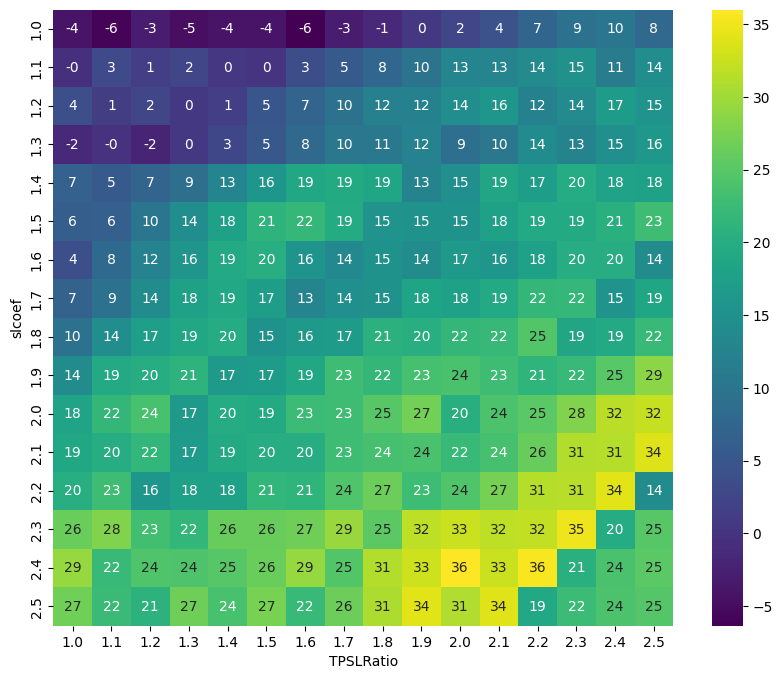

In [66]:
# Nasdaq index, 1 year period 1 hour interval
# Use MACD and EMA to generate trade signals

tradingData = read_data('^ixic', '1y', '1h')
tradingData = set_ema(tradingData, 200)
tradingData = set_macd(tradingData)
tradingData = set_atr(tradingData)
tradingData = set_ema_trade_signal(tradingData)
tradingData = set_macd_trade_signal(tradingData)
tradingData = set_total_trade_signal(tradingData)

print(f'number of trades: {tradingData[tradingData.Total_trade_signal != 0].shape[0]}')

backtest = Backtest(tradingData, MacdStrategy, cash=25000, margin=1/30, commission=0.00)
stats, heatmap = backtest.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    #rsi_length=[5, 8, 10, 12, 14, 16],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
print(stats)
show_heatmap(heatmap)


100%|██████████| 1756/1756 [00:00<00:00, 173123.61it/s]

number of trades: 126



/var/folders/rk/xympl3kj42nf5b5zvnt_lrxh0000gn/T/ipykernel_63905/3169248241.py:22: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  backtest = Backtest(tradingData, MacdStrategy, cash=25000, margin=1/30, commission=0.00)
/Users/andrew/.pyenv/versions/3.11.4/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                    1755.0
Duration                               1755.0
Exposure Time [%]                   64.920273
Equity Final [$]                 32104.441788
Equity Peak [$]                  33945.657337
Return [%]                          28.417767
Buy & Hold Return [%]               26.184365
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -14.78901
Avg. Drawdown [%]                   -1.280883
Max. Drawdown Duration                  936.0
Avg. Drawdown Duration              34.478261
# Trades                                 62.0
Win Rate [%]                        37.096774
Best Trade [%]                       3.632565
Worst Trade [%]                     -2.275865
Avg. Trade [%]                    

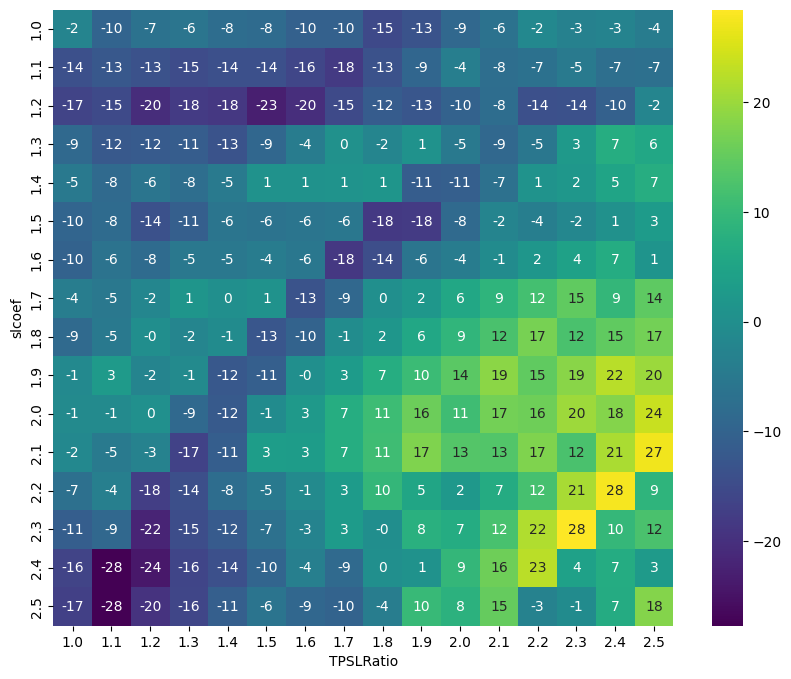

In [64]:
# Nasdaq index, 1 year period 1 hour interval
# Use MACD to generate trade signals

def total_trade_signal(row):
    if (row.MACD_trade_signal == 1):
        return 1
    elif (row.MACD_trade_signal == -1):
        return -1
    else:
        return 0

tradingData = read_data('^ixic', '1y', '1h')
# tradingData = set_ema(tradingData, 200)
tradingData = set_macd(tradingData)
tradingData = set_atr(tradingData)
# tradingData = set_ema_trade_signal(tradingData)
tradingData = set_macd_trade_signal(tradingData)
tradingData = set_total_trade_signal(tradingData)

print(f'number of trades: {tradingData[tradingData.Total_trade_signal != 0].shape[0]}')

backtest = Backtest(tradingData, MacdStrategy, cash=25000, margin=1/30, commission=0.00)
stats, heatmap = backtest.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    #rsi_length=[5, 8, 10, 12, 14, 16],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
print(stats)
show_heatmap(heatmap)
